# Building a Spam Filter with Naive Bayes

Most people, including myself, take for granted the usefulness of the spam filter on their email inboxes. It saves us alot of time and hassel sorting through junk, and protects us from harmful content.

The objective of this project is to develop a similar filter for the SMS messages received on our mobile devices. To do that we'll "teach" the computer to classify messages as spam or not spam using the multinomial Naive Bayes algorithm along with a dataset of 5572 SMS messages that are already classified by humans. 

The dataset was put together by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection).

Let's start by reading in the dataset.

In [1]:
# Import Pandas
import pandas as pd
# Read in dataset
sms = pd.read_csv("/Users/katestone/Downloads/SMSSpamCollection", header=None, names=["Label", "SMS"], sep="\t")
# Print rows and columns
sms.shape

(5572, 2)

In [2]:
# Distribution spam vs non-spam
sms["Label"].value_counts(normalize=True)*100

ham     86.593683
spam    13.406317
Name: Label, dtype: float64

We see above that of the 5572 SMS messages in the dataset, 13.4% have been classified by humans as spam. 

# Break the Data into Training and Test Sets

Before creating the spam filter we need to set aside some of the data which we will use to test how accurately it classifies messages. We'll split the dataset as follows:
- A training set, which we'll use to "train" the computer how to classify messages. This will comprise 80% of the dataset (4458 entries);
- A test set, which we'll use to test how good the spam filter is with classifying new messages. This will comprise 20% of the dataset (1114 entries). 

Once we've developed the spam filter we'll compare the algorithm classification with that done by a human using the test set. Our goal is for the algorithm to accurately classify messages atleast 80% of the time. Therefore if the algorithm classification agrees with the human classification on atleast 80% of the 1114 messages in the test set, we'll know that we've met our goal. 

In [3]:
# Randomise entire dataset
sms_random = sms.sample(frac=1, random_state=1)
# Calculate index for split
sms_training_test_index = round(len(sms_random)*0.80)
# Create training set with 80% of data
sms_training = sms_random[:sms_training_test_index].reset_index(drop=True)
# Create test set with 20% of data
sms_test = sms_random[sms_training_test_index:].reset_index(drop=True)
print(sms_training.shape)
print(sms_test.shape)

(4458, 2)
(1114, 2)


In [4]:
# Check distribution of spam vs non-spam in training set
sms_training["Label"].value_counts(normalize=True)*100

ham     86.54105
spam    13.45895
Name: Label, dtype: float64

In [5]:
# Check distribution of spam vs non-spam in test set
sms_test["Label"].value_counts(normalize=True)*100

ham     86.804309
spam    13.195691
Name: Label, dtype: float64

We can see that the percentages of spam and non-spam in each new dataset are pretty similar to what we have in the full dataset. 
# Clean the Datasets

To apply to the Naive Bayes algorithm to the SMS messages we need to clean and transform the data. Lets start by removing punctuation and bringing all of the words to lower case.

In [6]:
# Remove all punctuation from the SMS column
sms_training["SMS"] = sms_training["SMS"].str.replace("\W"," ")
# Transform all letters to lower case
sms_training["SMS"] = sms_training["SMS"].str.lower()
# Check Transformation
sms_training.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


# Create Vocabulary of Unique Words

The next step will be to create a python list of all the unique words used across all messages. We call this list a "vocabulary". 

In [7]:
# Transform each message from the SMS column into a list
sms_training["SMS"] = sms_training["SMS"].str.split()

In [8]:
# Create empty list
vocabulary = []
# Iterate of SMS column to extract unique words
for sms in sms_training["SMS"]:
    for string in sms:
        vocabulary.append(string)
# Transform vocabulary list into set to remove duplicates
vocab_set = set(vocabulary)
# Tranform back to list
vocabulary = list(vocab_set)

In [9]:
len(vocabulary)

7783

# Create the Final Training Set

We'll now use the vocabulary above to create the data transformation we want.

In [10]:
# Create dictionary containing word counts pers sms
word_counts_per_sms = {unique_word: [0] * len(sms_training['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(sms_training['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [11]:
# Transform dictionary into dataframe
word_counts_df = pd.DataFrame(word_counts_per_sms)
word_counts_df.head()

,sane,nw,photos,auto,24m,woods,starer,pei,attitude,burning,...,139,created,09099725823,2mwen,audiitions,owned,yourself,feels,heavy,anymore
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# Concat word_counts_df with sms_training
sms_training_final = pd.concat([sms_training, word_counts_df], axis=1)
sms_training_final.head()

,Label,SMS,sane,nw,photos,auto,24m,woods,starer,pei,...,139,created,09099725823,2mwen,audiitions,owned,yourself,feels,heavy,anymore
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Calculate Constants

We've now finished cleaning the dataset and can commence creating the spam filter. The Naive Bayes algorithm will need to answer these two probability questions to be able to classify new messages:

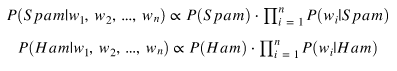

Also, to calculate $P(w_i|Spam)$ and $P(w_i|Ham)$ inside the formulas above, we'll need to use these equations:

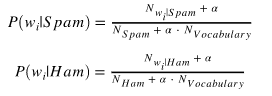

Lets start by calculating the following constants:
- P(Spam): Probability of the message being spam.
- P(Ham): Probability of the message not being spam.
- N_Spam: Number of words in all the spam messages.
- N_Ham: Number of words in all the non-spam messages.
- N_Vocabulary: Number of unique words in the vocabulary.

We'll also use Laplace smoothing and set $\alpha = 1$.

In [13]:
# Calculate P(Spam)
p_spam = len(sms_training_final[sms_training_final["Label"] == 'spam'])/len(sms_training_final)
# Calculate P(Ham)
p_ham = len(sms_training_final[sms_training_final["Label"] == 'ham'])/len(sms_training_final)

#Check values
print(p_spam)
print(p_ham)

0.13458950201884254
0.8654104979811574


In [14]:
# Calculate N_Spam
n_spam = 0
for sms in sms_training_final["SMS"][sms_training_final["Label"] == 'spam']:
    for word in sms:
        if word != " ":
            n_spam += 1
            
# Calculate N_Ham)
n_ham = 0
for sms in sms_training_final["SMS"][sms_training_final["Label"] == 'ham']:
    for word in sms:
        if word != " ":
            n_ham += 1
            
# Calculate N_Vocabulary)
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1

# Calculate Parameters

Now that we have the constant terms calculated above, we can move on to calculating the parameters $P(w_i|Spam)$ and $P(w_i|Ham)$. Each parameter will thus be a conditional probability value associated with each word in the vocabulary.

The parameters are calculated using the formulas:

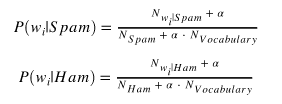

In [16]:
# Initialise two dictionaries
parameters_spam = {}
parameters_ham = {}
for word in vocabulary:
    key = word
    value = 0
    parameters_spam[key] = value
    parameters_ham[key] = value

In [17]:
# Isolate spam and the ham messages into two different dataframes
spam_messages = pd.DataFrame(sms_training_final[sms_training_final["Label"] == "spam"])
ham_messages = pd.DataFrame(sms_training_final[sms_training_final["Label"] == "ham"])

In [18]:
# Iterate over vocabulary calculate P(wi|Spam) and P(wi|Ham) 
for word in vocabulary:
    n_w_given_spam = spam_messages[word].sum()
    p_w_given_spam = (n_w_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    parameters_spam[word] = p_w_given_spam
    
    n_w_given_ham = ham_messages[word].sum()
    p_w_given_ham = (n_w_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
    parameters_ham[word] = p_w_given_ham

# Write Spam Filter Function

The spam filter can be understood as a function that operates as follows:

- Takes in as input a new message (w1, w2, ..., wn);
- Calculates P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn);
- Compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn); and:
    - If P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn), then the message is classified as ham;
    - If P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn), then the message is classified as spam;
    - If P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn), then the algorithm may request human help.

Lets begin writing the function.

In [19]:
# Import re
import re
# Define spam classification function
def classify(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
            
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)

    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [20]:
# Test function
known_spam = classify('WINNER!! This is the secret code to unlock the money: C3421.')
print('\n')
known_non_spam = classify("Sounds good, Tom, then see u there")

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


The spam filter appears to be working as intended.

# Apply Spam Filter to Test Data

We'll now try to determine how well the spam filter does on our test set of 1,114 messages. The algorithm will output a classification label for every message in our test set, which we'll be able to compare with the actual label (given by a human). 

In [21]:
# Modify function to return label instead of print
def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham
    
    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_ham_given_message < p_spam_given_message:
        return 'spam'
    else:
        return 'needs human classification'

In [22]:
# Apply function to test data
sms_test["Predicted"] = sms_test["SMS"].apply(classify_test_set)
# Check
sms_test.head()

,Label,SMS,Predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


# Measure Accuracy of Spam Filter

Our next step will be to measure the accuracy of spam filter. Remember, we want to the spam filter to get the classification right atleast 80% of the time.

In [23]:
# Measure the accuracy of the spam filter
correct = 0
total = len(sms_test)
for row in sms_test.iterrows():
    row = row[1]
    if row["Label"] == row["Predicted"]:
        correct += 1
        
accuracy = (correct/total)*100
print(accuracy)

98.74326750448833


The accuracy is close to 98.74%, which is really good. Our spam filter looked at 1114 messages that it hasn't seen in training, and classified 1100 correctly.

# Next Steps

In this project, we managed to build a spam filter for SMS messages using the multinomial Naive Bayes algorithm. The filter had an accuracy of 98.74% on the test set we used, which is a pretty good result. Our initial goal was an accuracy of over 80%, and we managed to do way better than that.

Next steps include:

Analyze the 14 messages that were classified incorrectly and try to figure out why the algorithm classified them incorrectly
Make the filtering process more complex by making the algorithm sensitive to letter case. 